In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree

In [2]:
from sqlalchemy import create_engine
from hold import connection_string

In [3]:
engine = create_engine(f'{connection_string}', encoding='iso-8859-1', connect_args={'connect_timeout': 10})

In [4]:
gtdDF = pd.read_sql_table('global_terrorism', con= engine)

In [5]:
casualties = gtdDF['nkill'] + gtdDF['nwound']
casualties.sum()

554384.0

In [6]:
gtdDF['casualties'] = gtdDF['nkill'] + gtdDF['nwound']
gtdDF.head()

,iyear,imonth,iday,date,country_txt,region_txt,provstate,city,latitude,longitude,...,weaptype1_txt,weapsubtype1_txt,weaptype2_txt,weapsubtype2_txt,kidhijcountry,ransom,nkill,nwound,index1,casualties
0,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,Firearms,Unknown Gun Type,None,None,None,NaN,0.0,7.0,1.0,7.0
1,2000,1,1,2000-01-01,Namibia,Sub-Saharan Africa,Kavango,Muitjiku,-17.91,19.99,...,Firearms,Unknown Gun Type,None,None,None,0.0,0.0,7.0,2.0,7.0
2,2000,1,1,2000-01-01,India,South Asia,Jammu and Kashmir,Udhampur,32.93,75.14,...,Firearms,Unknown Gun Type,None,None,None,NaN,1.0,2.0,3.0,3.0
3,2000,1,1,2000-01-01,Kosovo,Eastern Europe,Kosovo (Province),Peje,42.66,20.31,...,Explosives/Bombs/Dynamite,Unknown Explosive Type,None,None,None,NaN,0.0,1.0,4.0,1.0
4,2000,1,1,2000-01-01,Somalia,Sub-Saharan Africa,Banaadir,Mogadishu,2.11,45.39,...,Firearms,Unknown Gun Type,None,None,None,NaN,6.0,10.0,5.0,16.0


In [7]:
RegionCasualtiesDF = gtdDF[['index1','region_txt','casualties']]
RegionCasualtiesDF = RegionCasualtiesDF.reset_index()
RegionCasualtiesDF.head()

,index,index1,region_txt,casualties
0,0,1.0,Sub-Saharan Africa,7.0
1,1,2.0,Sub-Saharan Africa,7.0
2,2,3.0,South Asia,3.0
3,3,4.0,Eastern Europe,1.0
4,4,5.0,Sub-Saharan Africa,16.0


In [8]:
# Multiply the dummies by the casualties so that the regression works for casualties
RegionCasualties2DF = pd.get_dummies(RegionCasualtiesDF['region_txt']).mul(RegionCasualtiesDF['casualties'],0)
RegionCasualties2DF = RegionCasualties2DF.reset_index()
RegionCasualties2DF.head()

,index,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0


In [9]:
RegionCasualtiesMergeDF = result = pd.merge(RegionCasualties2DF,RegionCasualtiesDF[['index','region_txt','casualties']],on='index')
RegionCasualtiesMergeDF.head()

,index,Australasia & Oceania,Central America & Caribbean,Central Asia,East Asia,Eastern Europe,Middle East & North Africa,North America,South America,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe,region_txt,casualties
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,Sub-Saharan Africa,7.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,Sub-Saharan Africa,7.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,South Asia,3.0
3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Eastern Europe,1.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,Sub-Saharan Africa,16.0


In [10]:
# Assign X (data) and y (target)
data = RegionCasualtiesMergeDF.drop(["index","region_txt",'casualties'], axis=1)
target = RegionCasualtiesMergeDF["region_txt"]
feature_names = data.columns

print(data.shape, target.shape)

(92700, 12) (92700,)


In [11]:
# Split the data into training and testing
### BEGIN SOLUTION
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)
### END SOLUTION

In [12]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7981877022653722

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7981877022653722

In [14]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.3646192502002896, 'Middle East & North Africa'),
 (0.26530722784538646, 'South Asia'),
 (0.14669984179200243, 'Sub-Saharan Africa'),
 (0.11996947600583653, 'Southeast Asia'),
 (0.04956954687292102, 'Eastern Europe'),
 (0.027068075080535277, 'South America'),
 (0.013846363739579627, 'Western Europe'),
 (0.00433636611750909, 'North America'),
 (0.003783271327387677, 'Central Asia'),
 (0.0030826329180114707, 'East Asia'),
 (0.001486428560577722, 'Central America & Caribbean'),
 (0.0002315195399628414, 'Australasia & Oceania')]

In [15]:
RFRegionDF = pd.DataFrame(sorted(zip(rf.feature_importances_, feature_names), reverse=True), columns = ['Probability', 'Region'])
RFRegionDF

,Probability,Region
0,0.364619,Middle East & North Africa
1,0.265307,South Asia
2,0.146700,Sub-Saharan Africa
3,0.119969,Southeast Asia
4,0.049570,Eastern Europe
5,0.027068,South America
6,0.013846,Western Europe
7,0.004336,North America
8,0.003783,Central Asia
9,0.003083,East Asia


In [16]:
pies = RFRegionDF['Region'].head(7)
pie_slices = RFRegionDF['Probability'].head(7)
colors = ["lightskyblue","orange","pink","yellowgreen","lightcoral","silver","yellow",
          "lightgreen","wheat","khaki"]
explode = (0.1,0,0,0,0,0,0)

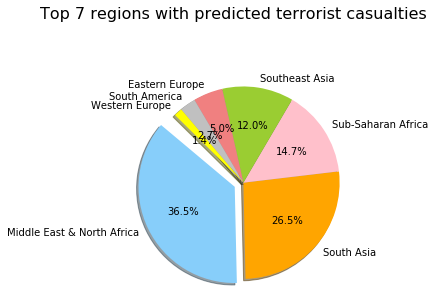

In [17]:
# Tell matplotlib to create a pie chart based upon the above data
plt.pie(pie_slices, explode=explode, labels=pies, colors=colors, 
        autopct="%1.1f%%", shadow=True, startangle=140)
# Create axes which are equal so we have a perfect circle
plt.axis("equal")
# Save an image of our chart and print the final product to the screen

plt.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML10_Region_Casualties_Pie_RF")
plt.suptitle('Top 7 regions with predicted terrorist casualties', size=16, y=1.12) 
plt.show()

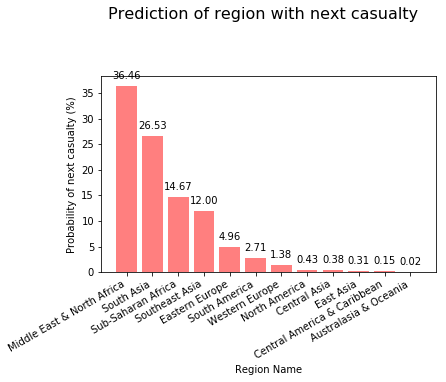

In [18]:
y_axis = RFRegionDF['Probability']*100
x_axis = RFRegionDF['Region']
fig, ax = plt.subplots()
# plot
ax.bar(x_axis, y_axis, color='r', alpha=0.5, align="center")

# Make space for and rotate the x-axis tick labels
fig.autofmt_xdate()

# Labels for x and y axes
plt.xlabel("Region Name")
plt.ylabel("Probability of next casualty (%)")

# Show the values of each probability on plot
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.
    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above. All the magic happens there.
add_value_labels(ax)

# Save an image of our chart and print the final product to the screen
plt.savefig("../GTA/front_end/static/front_end/assets/visualizations/ML10_Region_Casualties_Bar_RF")
# Title for the chart
plt.suptitle('Prediction of region with next casualty', size=16, y=1.12) 
plt.show()
